In [122]:
%pip install --quiet --upgrade torch torchvision pillow sentence-transformers faiss-cpu pandas

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lancedb/__init__.py:220: UserWarning: lance is not fork-safe. If you are using multiprocessing, use spawn instead.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Image-based Semantic Search

## aka searching by vibes

When AI models "think" about a cat, they don't actually think about my adorable cats. They think about the *mathematical representation* of a cat.

When multimodal models represent the *word* cat in their tiny electric brains, it's similar to when they represent an *image* of a cat. We can use this to build a **text search engine of images**.

In [89]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('clip-ViT-B-32')

modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

0_CLIPModel/pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Let's take this model and see what it thinks about when you tell it the word "cat".

In [124]:
embedding = model.encode('cat')
embedding[:200]

array([ 2.05169529e-01, -3.27931195e-02, -6.16611987e-02, -3.97020578e-02,
       -2.43344292e-01,  2.19644815e-01, -3.42003137e-01,  1.24627754e-01,
       -3.63257647e-01,  2.84492791e-01,  5.94428927e-03, -4.85526711e-01,
        2.44809836e-01, -7.51996711e-02,  3.48670542e-01,  4.41847742e-01,
        1.70990616e-01, -2.16987237e-01, -7.97683820e-02,  7.81797990e-02,
        4.10218120e-01,  3.06924641e-01,  2.49375463e-01,  1.01653293e-01,
       -1.96155861e-01,  3.65464032e-01,  3.52477133e-01,  6.31474316e-01,
       -6.22387230e-03,  3.17167491e-03,  1.12121925e-01, -1.25247240e-02,
        1.71803594e-01,  1.75178945e-01, -9.13281515e-02,  1.63207844e-01,
        1.75419062e-01,  3.21536064e-01,  3.61862153e-01,  1.92362174e-01,
       -1.82834826e-03, -1.87393501e-02,  2.33572856e-01,  2.74105608e-01,
        1.74107552e-01,  2.32931241e-01, -6.65666685e-02, -2.33122602e-01,
       -2.03813016e-01, -2.75065005e-02,  1.02608338e-01,  1.20114312e-02,
        2.60149837e-01,  

Ah, yes, sure, me too! And if we look at an image of a cat?

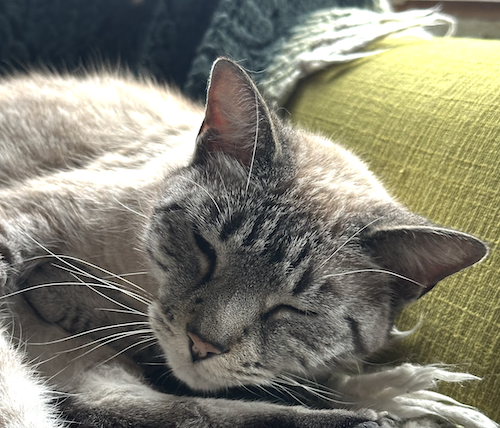

In [127]:
from PIL import Image

image = Image.open("cat.png").convert("RGB")
image

In [128]:
embedding = model.encode('cat')
embedding[:200]

array([ 2.05169529e-01, -3.27931195e-02, -6.16611987e-02, -3.97020578e-02,
       -2.43344292e-01,  2.19644815e-01, -3.42003137e-01,  1.24627754e-01,
       -3.63257647e-01,  2.84492791e-01,  5.94428927e-03, -4.85526711e-01,
        2.44809836e-01, -7.51996711e-02,  3.48670542e-01,  4.41847742e-01,
        1.70990616e-01, -2.16987237e-01, -7.97683820e-02,  7.81797990e-02,
        4.10218120e-01,  3.06924641e-01,  2.49375463e-01,  1.01653293e-01,
       -1.96155861e-01,  3.65464032e-01,  3.52477133e-01,  6.31474316e-01,
       -6.22387230e-03,  3.17167491e-03,  1.12121925e-01, -1.25247240e-02,
        1.71803594e-01,  1.75178945e-01, -9.13281515e-02,  1.63207844e-01,
        1.75419062e-01,  3.21536064e-01,  3.61862153e-01,  1.92362174e-01,
       -1.82834826e-03, -1.87393501e-02,  2.33572856e-01,  2.74105608e-01,
        1.74107552e-01,  2.32931241e-01, -6.65666685e-02, -2.33122602e-01,
       -2.03813016e-01, -2.75065005e-02,  1.02608338e-01,  1.20114312e-02,
        2.60149837e-01,  

I'm not going to go through those numbers, but I guarantee they have some similarities!

## Processing images

So this becomes useful when you have a bunch of images and want to search through them. You create embeddings for your images, embed your search term, and then say "find me all of the images that are kind of similar to this search term."

We're going to use a collection of tattoo and non-tattoo images from a machine-learning project I did a few years ago. The process of building an embedding index works like this:

In [106]:
import glob
from tqdm import tqdm
from PIL import Image

filenames = glob.glob("tattoos/*.jp*")
data = []

embeddings = []
for path in tqdm(filenames):
    image = Image.open(path).convert("RGB")
    embedding = model.encode(image)
    embeddings.append(embedding)


100%|██████████| 469/469 [00:23<00:00, 19.84it/s]


We're using [FAISS](https://github.com/facebookresearch/faiss) which is absolutely overkill, but oh well.

In [107]:
import faiss
import numpy as np

embedding_matrix = np.vstack(embeddings).astype('float32')
faiss.normalize_L2(embedding_matrix)

index = faiss.IndexFlatIP(embedding_matrix.shape[1])
index.add(embedding_matrix)

## Search by text

To find images that match a text query, we just encode the text and say "find me things that are similar!"

In [116]:
query = "colorful bird"
match_count = 10

query_embedding = model.encode(query, convert_to_numpy=True).astype('float32')
faiss.normalize_L2(query_embedding.reshape(1, -1))
D, I = index.search(query_embedding.reshape(1, -1), match_count)

matches = [filenames[i] for i in I[0]]
scores = D[0]

for filename, score in zip(matches, scores):
    print(f"{filename}: {score}")

tattoos/892.jpg: 0.278444766998291
tattoos/1322.jpg: 0.2774106562137604
tattoos/1333.jpg: 0.2773348093032837
tattoos/358.jpg: 0.2666137218475342
tattoos/704.jpg: 0.2618109881877899
tattoos/576.jpg: 0.2617538571357727
tattoos/408.jpg: 0.2593039274215698
tattoos/653.jpg: 0.2551579475402832
tattoos/414.jpg: 0.2538231909275055
tattoos/83.jpg: 0.2534153163433075


In [115]:
from IPython.display import HTML
import pandas as pd

df = pd.DataFrame({
    'scores': scores,
    'filename': matches,
    'query': query
})
df['preview'] = df['filename'].apply(lambda filename: f'<img src="{filename}" width="100"/>')


HTML(df.to_html(escape=False))

,scores,filename,query,preview
0,0.278445,tattoos/892.jpg,colorful bird,
1,0.277411,tattoos/1322.jpg,colorful bird,
2,0.277335,tattoos/1333.jpg,colorful bird,
3,0.266614,tattoos/358.jpg,colorful bird,
4,0.261811,tattoos/704.jpg,colorful bird,
5,0.261754,tattoos/576.jpg,colorful bird,
6,0.259304,tattoos/408.jpg,colorful bird,
7,0.255158,tattoos/653.jpg,colorful bird,
8,0.253823,tattoos/414.jpg,colorful bird,
9,0.253415,tattoos/83.jpg,colorful bird,


## Search by image

To find images that are similar to another image (with 'similar' having no true controllable meaning), we just encode the image and say "find me things that are similar!"

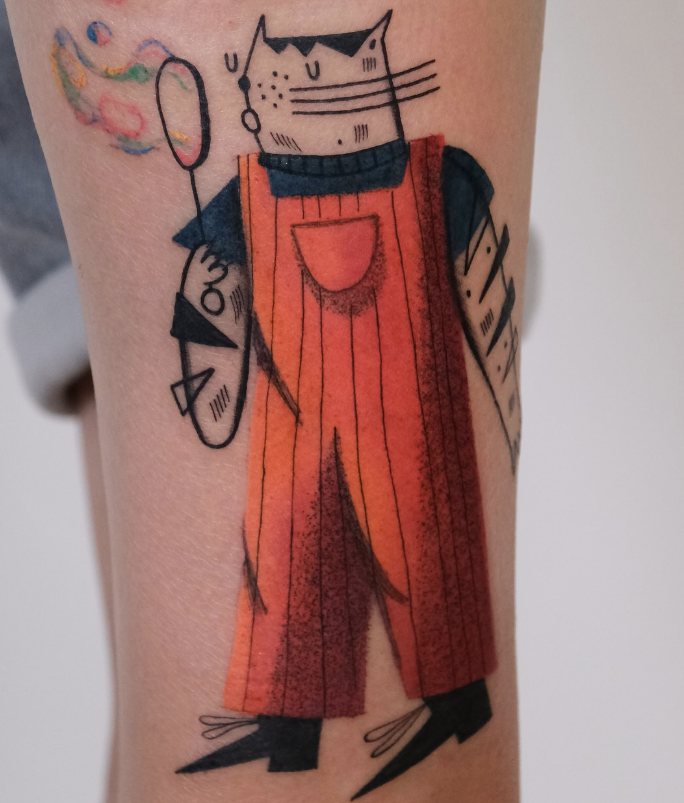

In [129]:
image = Image.open('tattoo.png').convert("RGB")
image

In [130]:
match_count = 10

query_embedding = model.encode(image, convert_to_numpy=True).astype('float32')
faiss.normalize_L2(query_embedding.reshape(1, -1))
D, I = index.search(query_embedding.reshape(1, -1), match_count)

matches = [filenames[i] for i in I[0]]
scores = D[0]

for filename, score in zip(matches, scores):
    print(f"{filename}: {score}")

tattoos/313.jpg: 0.8506867289543152
tattoos/738.jpg: 0.8409086465835571
tattoos/882.jpg: 0.8393253087997437
tattoos/1338.jpg: 0.8380718231201172
tattoos/1174.jpg: 0.8312423825263977
tattoos/330.jpg: 0.8295189738273621
tattoos/1118.jpg: 0.823896050453186
tattoos/182.jpg: 0.8226847052574158
tattoos/469.jpg: 0.821453332901001
tattoos/511.jpg: 0.8209567666053772


In [131]:
from IPython.display import HTML
import pandas as pd

df = pd.DataFrame({
    'scores': scores,
    'filename': matches,
})
df['preview'] = df['filename'].apply(lambda filename: f'<img src="{filename}" width="100"/>')


HTML(df.to_html(escape=False))

,scores,filename,preview
0,0.850687,tattoos/313.jpg,
1,0.840909,tattoos/738.jpg,
2,0.839325,tattoos/882.jpg,
3,0.838072,tattoos/1338.jpg,
4,0.831242,tattoos/1174.jpg,
5,0.829519,tattoos/330.jpg,
6,0.823896,tattoos/1118.jpg,
7,0.822685,tattoos/182.jpg,
8,0.821453,tattoos/469.jpg,
9,0.820957,tattoos/511.jpg,


Why are they similar? NO IDEA. *Because the model thinks so.*